### Check input files



In [136]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('../datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../datasets/sample.csv
../datasets/firstDataset.csv


### Import train data and create DataFrame object

In [137]:
numeric_data = pd.read_csv('../datasets/firstDataset.csv')
print("The files have been imported")


The files have been imported


### Find and display unique data
#### This function is used to search a Data Frame and then display unique values for each feature. Thanks to this, you can find features that have the same values, e.q: `OnlineSecurity` which contains the answers: 'Yes', 'No' and 'No internet service'.

In [138]:
def printUniqueValues(dataToCheck):
    for column in dataToCheck:
        uniqueValues = dataToCheck[column].unique()
        uniqueCount = len(uniqueValues)
        print(f"{column} = {uniqueValues} = {uniqueCount}")


printUniqueValues(numeric_data)


Dst Port = [    0    22    80 ... 46898  2041  2178] = 18567
Protocol = [ 0  6 17] = 3
Timestamp = ['14/02/2018 08:31:01' '14/02/2018 08:33:50' '14/02/2018 08:36:39' ...
 '14/02/2018 01:51:56' '14/02/2018 01:49:38' '14/02/2018 01:47:38'] = 32043
Flow Duration = [112641719 112641466 112638623 ...   5095331   5235511   5807256] = 389493
Tot Fwd Pkts = [   3   15   14   16    5    1   91   11    6    4   41   23   10  975
 1038  125 1041  555   25   22   21   26   24   20   27   19   28    2
   52   17   12   13    9    7    8   51  533 4909   54   18   29   31
   39   97   35   58   32   79   55  120   43   36  126  129  130   99
  178  205   50   74   33   77   47  226   71   44   87   30   40  162
   42  105   60   49  112   37   96  123   34   48  151  310  153   53
   70  106   85  636   90   59   57   76  496  149   69   46   72   68
   45  133  155  134  390   38   67  180   73   86   83  282  234  107
  633  667   56  425  230   93   82 4352  597  341  271   62  115  405
   61  11

### DataFrame information
#### The `info()` method provides us a basic information about featurs, like: feature's amout of data (how many values are NaN values) and the types of data (e.q int or float). It is very important information for future data processing beacuse, e.q: fetures which contains variables of type 'int' will be labeled differently than features which contains variables of type 'float'.

In [139]:
numeric_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

### Preprocess training data.

In [140]:
display(numeric_data)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


Drop unnecessary features

In [141]:
def dropUnnecessaryFeatures(dataToTransform):
    dataToTransform = dataToTransform.drop(['Timestamp'], axis=1)

    dataToTransform = dataToTransform.drop(['Fwd Pkt Len Min'], axis=1)
    dataToTransform = dataToTransform.drop(['Fwd Pkt Len Max'], axis=1)

    dataToTransform = dataToTransform.drop(['Bwd Pkt Len Min'], axis=1)
    dataToTransform = dataToTransform.drop(['Bwd Pkt Len Max'], axis=1)

    dataToTransform = dataToTransform.drop(['Flow IAT Min'], axis=1)
    dataToTransform = dataToTransform.drop(['Flow IAT Max'], axis=1)

    dataToTransform = dataToTransform.drop(['Fwd IAT Max'], axis=1)
    dataToTransform = dataToTransform.drop(['Fwd IAT Min'], axis=1)

    dataToTransform = dataToTransform.drop(['Bwd IAT Max'], axis=1)
    dataToTransform = dataToTransform.drop(['Bwd IAT Min'], axis=1)

    dataToTransform = dataToTransform.drop(['Pkt Len Min'], axis=1)
    dataToTransform = dataToTransform.drop(['Pkt Len Max'], axis=1)

    dataToTransform = dataToTransform.drop(['Idle Max'], axis=1)
    dataToTransform = dataToTransform.drop(['Idle Min'], axis=1)

    dataToTransform = dataToTransform.drop(['Active Max'], axis=1)
    dataToTransform = dataToTransform.drop(['Active Min'], axis=1)

    # "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s"
    return dataToTransform


train = dropUnnecessaryFeatures(numeric_data)
display(numeric_data)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [142]:

print(numeric_data['Init Bwd Win Byts'])


0             -1
1             -1
2             -1
3            233
4            233
           ...  
1048570    31111
1048571       -1
1048572    29200
1048573    42780
1048574      110
Name: Init Bwd Win Byts, Length: 1048575, dtype: int64


In [143]:
from sklearn.preprocessing import StandardScaler


def scale(dataToTransform, columntoTransform):

    ss_dict = {col: StandardScaler() for col in columntoTransform}

    for colKey in columntoTransform:
        dataToTransform[colKey] = ss_dict[colKey].fit_transform(
            np.array(dataToTransform[colKey]).reshape(-1, 1))

    return dataToTransform


In [144]:
numericColumntoTransform = ['Flow Duration',
                            'Init Fwd Win Byts', 'Init Bwd Win Byts']
numeric_data = scale(numeric_data, numericColumntoTransform)


In [145]:
print(numeric_data['Init Fwd Win Byts'])


0         -0.811826
1         -0.811826
2         -0.811826
3          4.253921
4         -0.362807
             ...   
1048570   -0.178530
1048571    4.153821
1048572   -0.178530
1048573   -0.178530
1048574   -0.178530
Name: Init Fwd Win Byts, Length: 1048575, dtype: float64


### Heatmap
#### Heatmap provide us information on how much the individual features are interpedent. Based on heatmap, we droped the feature that are high corelated with each other, beacuse, such data do not provide additional information and can increase the model load. For example, we drop `TotalCharges` because it's has high corellation with `MonthlyCharges`.

<AxesSubplot:>

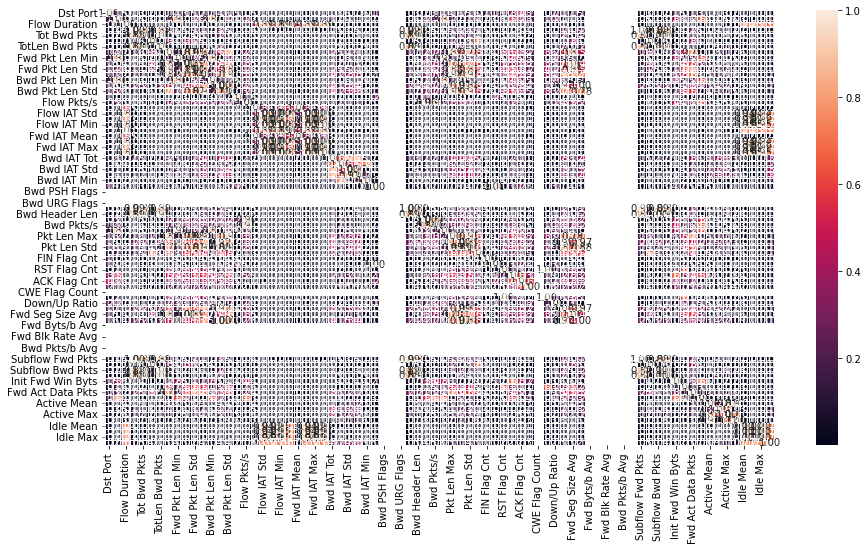

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(abs(numeric_data.corr()), annot=True,
            linewidths=0.5, fmt='.2f', ax=ax)


#### Process labels

#### Before preprocess

In [147]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)


def showAttackDistribution(data):
    normal = 'Benign'
    ftpAttack = 'FTP-BruteForce'
    sshAttack = 'SSH-Bruteforce'
    fig = go.Figure(data=[
        go.Bar(name=normal,
               y=data.value_counts().values[0:1],
               x=[normal],
               text=data.value_counts()[0:1],
               orientation='v',
               textposition='outside',),
        go.Bar(name=ftpAttack,
               y=data.value_counts().values[1:2],
               x=[ftpAttack],
               text=data.value_counts()[1:2],
               orientation='v',
               textposition='outside',),
        go.Bar(name=sshAttack,
               y=data.value_counts().values[2:],
               x=[sshAttack],
               text=data.value_counts()[2:],
               orientation='v',
               textposition='outside',)
    ])
    # Change the bar mode
    fig.update_layout(
        width=800,
        height=600,
        title=f'Labels Distribution',
        yaxis_title='Number of attacks',
        xaxis_title='Attack Name',)
    iplot(fig)


In [148]:
showAttackDistribution(numeric_data['Label'])


In [149]:
def shortData(data, featureName):
    shortedNormal = data[data[featureName] == "Benign"][:5000]
    shortedFTP = data[data[featureName] == "FTP-BruteForce"][:5000]
    shortedSSH = data[data[featureName] == "SSH-Bruteforce"][:5000]
    return pd.concat([shortedNormal, shortedFTP, shortedSSH], axis=0)


In [150]:
numeric_data = shortData(numeric_data, 'Label')

In [151]:
from sklearn.preprocessing import LabelEncoder


def labelEncodeTypeAttack(dataToTransform):
    dataToTransform = LabelEncoder().fit_transform(
        dataToTransform)

    return dataToTransform


In [152]:
numeric_data['Label'] = labelEncodeTypeAttack(numeric_data['Label'])
unique, counts = np.unique(numeric_data['Label'], return_counts=True)
dict(zip(unique, counts))


{0: 5000, 1: 5000, 2: 5000}

In [153]:
numeric_data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,0.084414,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,0
1,0,0,14/02/2018 08:33:50,0.084414,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,0
2,0,0,14/02/2018 08:36:39,0.084412,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,0
3,22,6,14/02/2018 08:40:13,0.000157,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
4,22,6,14/02/2018 08:40:23,0.002022,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184441,22,6,14/02/2018 02:06:39,-0.004631,22,22,1992,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,2
184442,22,6,14/02/2018 02:06:39,-0.004663,22,22,2008,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,2
184443,22,6,14/02/2018 02:06:39,-0.004662,23,20,2008,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,2
184444,22,6,14/02/2018 02:06:39,-0.004676,22,22,2008,2665,640,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,2
